In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

from evaluation_and_testing.evaluation_measures import *
from evaluation_and_testing.testing import *

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


False

# Load the dataset for recommenders

In [3]:
data_path = os.path.join("data", "hotel_data")

interactions_df = pd.read_csv(os.path.join(data_path, "hotel_data_interactions_df.csv"), index_col=0)

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear', 'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_df.loc[:, 'term'] = pd.Categorical(
    interactions_df['term'], categories=column_values_dict['term'])
interactions_df.loc[:, 'length_of_stay_bucket'] = pd.Categorical(
    interactions_df['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_df.loc[:, 'rate_plan'] = pd.Categorical(
    interactions_df['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_df.loc[:, 'room_segment'] = pd.Categorical(
    interactions_df['room_segment'], categories=column_values_dict['room_segment'])
interactions_df.loc[:, 'n_people_bucket'] = pd.Categorical(
    interactions_df['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_df.loc[:, 'weekend_stay'] = interactions_df['weekend_stay'].astype('str')
interactions_df.loc[:, 'weekend_stay'] = pd.Categorical(
    interactions_df['weekend_stay'], categories=column_values_dict['weekend_stay'])

display(HTML(interactions_df.head(15).to_html()))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[160-260],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[260-360],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[260-360],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


# (Optional) Prepare numerical user features

The method below is left here for convenience if you want to experiment with content-based user features as an input for your neural network.

In [4]:
def n_to_p(l):
    n = sum(l)
    return [x / n for x in l] if n > 0 else l

def calculate_p(x, values):
    counts = [0]*len(values)
    for v in x:
        counts[values.index(v)] += 1

    return n_to_p(counts)

def prepare_users_df(interactions_df):
    ######################
    # this function returns dataframe with float values based on number
    # of times user interacted with item with said feature
    ######################
    users_df = interactions_df.copy()
    #this line is to narrow number of used features
    
#     users_df = users_df.loc[:,["user_id","term","length_of_stay_bucket","n_people_bucket", "room_segment"]]
#     users_df = users_df.loc[:,["user_id","term", "room_segment"]]

    users_df = pd.get_dummies(users_df)
    users_df = users_df.loc[:,users_df.columns != "item_id"]
    users_df = users_df.groupby(['user_id']).sum()

    users_df = users_df / users_df.sum(axis=1).values.reshape(-1, 1)
    users_df = users_df.add_prefix('user_')
    users_df = users_df.rename_axis(None, axis=1).fillna(0).reset_index()
    user_features = users_df.loc[:,users_df.columns != "user_id"].columns.to_list()
    
    
    return users_df, user_features
    

users_df, user_features = prepare_users_df(interactions_df)

u_data = users_df.loc[:, users_df.columns != "user_id"].to_numpy()
print(users_df.loc[users_df["user_id"] == 7])




   user_id  user_term_WinterVacation  user_term_Easter  user_term_OffSeason  \
6        7                       0.0               0.0             0.166667   

   user_term_HighSeason  user_term_LowSeason  user_term_MayLongWeekend  \
6                   0.0                  0.0                       0.0   

   user_term_NewYear  user_term_Christmas  user_length_of_stay_bucket_[0-1]  \
6                0.0                  0.0                               0.0   

   ...  user_room_segment_[160-260]  user_room_segment_[260-360]  \
6  ...                          0.0                     0.166667   

   user_room_segment_[360-500]  user_room_segment_[500-900]  \
6                          0.0                          0.0   

   user_n_people_bucket_[1-1]  user_n_people_bucket_[2-2]  \
6                         0.0                         0.0   

   user_n_people_bucket_[3-4]  user_n_people_bucket_[5-inf]  \
6                         0.0                      0.166667   

   user_weekend_sta

# (Optional) Prepare numerical item features

The method below is left here for convenience if you want to experiment with content-based item features as an input for your neural network.

In [5]:
def map_items_to_onehot(df):
    one_hot = pd.get_dummies(df.loc[:, base_item_features])
    df = df.drop(base_item_features, axis = 1)
    df = df.join(one_hot)
    
    return df, list(one_hot.columns)

def prepare_items_df(interactions_df):
    items_df = interactions_df.loc[:, ["item_id"] + base_item_features].drop_duplicates()
    
    items_df, item_features = map_items_to_onehot(items_df)
    
    return items_df, item_features


items_df, item_features = prepare_items_df(interactions_df)

print(item_features)

x = items_df.loc[items_df['item_id'] == 760]
x = x.loc[:, items_df.columns != "item_id"].to_numpy()
display(x)

['term_WinterVacation', 'term_Easter', 'term_OffSeason', 'term_HighSeason', 'term_LowSeason', 'term_MayLongWeekend', 'term_NewYear', 'term_Christmas', 'length_of_stay_bucket_[0-1]', 'length_of_stay_bucket_[2-3]', 'length_of_stay_bucket_[4-7]', 'length_of_stay_bucket_[8-inf]', 'rate_plan_Standard', 'rate_plan_Nonref', 'room_segment_[0-160]', 'room_segment_[160-260]', 'room_segment_[260-360]', 'room_segment_[360-500]', 'room_segment_[500-900]', 'n_people_bucket_[1-1]', 'n_people_bucket_[2-2]', 'n_people_bucket_[3-4]', 'n_people_bucket_[5-inf]', 'weekend_stay_True', 'weekend_stay_False']


array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1]], dtype=uint8)

# Neural network recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Code a recommender based on a neural network model. You are free to choose any network architecture you find appropriate. The network can use the interaction vectors for users and items, embeddings of users and items, as well as user and item features (you can use the features you developed in the first project).

Remember to keep control over randomness - in the init method add the seed as a parameter and initialize the random seed generator with that seed (both for numpy and pytorch):

```python
self.seed = seed
self.rng = np.random.RandomState(seed=seed)
```
in the network model:
```python
self.seed = torch.manual_seed(seed)
```

You are encouraged to experiment with:
  - the number of layers in the network, the number of neurons and different activation functions,
  - different optimizers and their parameters,
  - batch size and the number of epochs,
  - embedding layers,
  - content-based features of both users and items.

In [29]:
from recommenders.recommender import Recommender


class Net(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, hidden_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.fc1 = nn.Linear(2 * embedding_dim, hidden_dim, bias=False)
        self.fc2 = nn.Linear(hidden_dim, int(hidden_dim / 2), bias=True)
        self.fc3 = nn.Linear(int(hidden_dim / 2), 1, bias=True)

    def forward(self, x):
        user = x[:, 0]
        item = x[:, 1]
        user_embedding = self.user_embedding(user)
        item_embedding = self.item_embedding(item)
        x = torch.cat([user_embedding, item_embedding], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x
    
class NetMF(nn.Module):
    def __init__(self, n_items, n_users, gmf_embedding_dim, mlp_embedding_dim, hidden_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)

        # GMF

        self.gmf_user_embedding = nn.Embedding(n_users, gmf_embedding_dim)
        self.gmf_item_embedding = nn.Embedding(n_items, gmf_embedding_dim)

        # MLP

        self.mlp_user_embedding = nn.Embedding(n_users, mlp_embedding_dim)
        self.mlp_item_embedding = nn.Embedding(n_items, mlp_embedding_dim)
        self.mlp_fc1 = nn.Linear(2 * mlp_embedding_dim, hidden_dim, bias=False)
        self.mlp_fc2 = nn.Linear(hidden_dim, int(hidden_dim / 2), bias=False)

        # Merge

        self.fc = nn.Linear(gmf_embedding_dim + int(hidden_dim / 2), 1, bias=False)

    def forward(self, x):
        user = x[:, 0]
        item = x[:, 1]

        # GMF

        gmf_user_embedding = self.gmf_user_embedding(user)
        gmf_item_embedding = self.gmf_item_embedding(item)
        gmf_x = gmf_user_embedding * gmf_item_embedding

        # MLP

        mlp_user_embedding = self.mlp_user_embedding(user)
        mlp_item_embedding = self.mlp_item_embedding(item)
        mlp_x = torch.cat([mlp_user_embedding, mlp_item_embedding], dim=1)
        mlp_x = torch.relu(self.mlp_fc1(mlp_x))
        mlp_x = torch.relu(self.mlp_fc2(mlp_x))

        # Final score

        x = torch.cat([gmf_x, mlp_x], dim=1)
        x = torch.sigmoid(self.fc(x))

        return x

class NNRecommender(Recommender):
    """
    Linear recommender class based on user and item features.
    """
#     n_neg_per_pos=10, batch_size=16,embedding_dim=6, lr=0.001, weight_decay=0.0001, n_epochs=3
    def __init__(self, seed=6789, n_neg_per_pos=3, embedding_dim=6, lr=0.0001, epochs=20, optimizer_type="ADAM", net_type="MF", should_recommend_already_bought=False, batch_size=16):
        """
        Initialize recommender params and variables.
        """
        self.model = None
        self.n_neg_per_pos = int(n_neg_per_pos)
        
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.users_df = None
        self.user_features = None
        
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        
        # You can add more arguments if needed
        # <<<Write your code here>>>
        self.most_popular_items = None
        self.n_epochs = int(epochs)
        self.lr = lr
        self.interactions = None
        self.item_id_mapping = None
        self.item_id_reverse_mapping = None
        self.user_id_mapping = None
        self.user_id_reverse_mapping = None
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.should_recommend_already_bought = should_recommend_already_bought
        self.embedding_dim=int(embedding_dim)
        self.batch_size=int(batch_size)
        self.optimizer = None
        self.weight_decay=0.0001
        self.optimizer_type = optimizer_type
        self.net_type = net_type

        
    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.
        
        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items 
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined by item_id and the item feature columns.
        """
        
        unique_item_ids = interactions_df['item_id'].unique()
        self.item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
        self.item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
        unique_user_ids = interactions_df['user_id'].unique()
        self.user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
        self.user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))
        
        
        interactions_df = interactions_df.copy()
        self.interactions = interactions_df
        n_users = np.max(interactions_df['user_id']) + 1
        n_items = np.max(interactions_df['item_id']) + 1
        
        r = np.zeros(shape=(n_users, n_items))
        for idx, interaction in interactions_df.iterrows():
            r[int(interaction['user_id'])][int(interaction['item_id'])] = 1

        
        # Generate negative interactions
        
        # <<<Write your code here>>>
        interactions_df["interacted"] = 1
        
        negative_interactions = []
       
        i = 0
        while i < self.n_neg_per_pos * len(interactions_df):
            sample_size = 1000
            user_ids = self.rng.choice(np.arange(n_users), size=sample_size)
            item_ids = self.rng.choice(np.arange(n_items), size=sample_size)

            j = 0
            while j < sample_size and i < self.n_neg_per_pos * len(interactions_df):
                if r[user_ids[j]][item_ids[j]] == 0:
                    negative_interactions.append([user_ids[j], item_ids[j], 0])
                    i += 1
                j += 1
        
        interactions_df = pd.concat(
            [interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        interactions_df = interactions_df.reset_index(drop=True)
       

        # Initialize the neural network model
        
        # <<<Write your code here>>>
        
        interaction_ids = self.rng.permutation(len(interactions_df))
        training_ids = interaction_ids
        validation_ids = []
        

        #         self.model = Net(self.seed,len(interactions_df))

        if(self.net_type == "MLP"):
            self.model = Net(n_items,n_users, self.embedding_dim, int(self.embedding_dim/2), self.seed)
        else:
            self.model = NetMF(n_items,n_users, self.embedding_dim*2, self.embedding_dim, int(self.embedding_dim/2), self.seed)
        self.model.train()
        self.model.to(self.device)
        
        if(self.optimizer_type == "SGD"):
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)
        else:
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        
        # Train the model using an optimizer
        
        # <<<Write your code here>>>
        
      
        training_losses = deque(maxlen=50)
        training_avg_losses = []
        training_epoch_losses = []
        validation_losses = deque(maxlen=50)
        validation_avg_losses = []
        validation_epoch_losses = []
        last_training_total_loss = 0.0
        last_validation_total_loss = 0.0
        for epoch in range(self.n_epochs):
#             print("Epoch " + str(epoch))
            # Train
            
            training_losses.clear()
            training_total_loss = 0.0
            
            self.rng.shuffle(training_ids)
            
            batch_idx = 0
            n_batches = int(np.ceil(len(training_ids) / self.batch_size))
            
            for batch_idx in range(n_batches):
#                 batch_ids = training_ids[(batch_idx * int(self.batch_size)):((batch_idx + 1) * int(self.batch_size))]
                batch_ids = training_ids[(batch_idx * self.batch_size):((batch_idx + 1) * self.batch_size)]
                
                batch = interactions_df.loc[batch_ids]
                batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)
                
                # Create responses

                y = self.model(batch_input).clip(0.000001, 0.999999)

                # Define loss and backpropagate

                self.optimizer.zero_grad()
                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                
                loss.backward()
                self.optimizer.step()
                
                training_total_loss += loss.item()
                
                
                training_losses.append(loss.item())
                training_avg_losses.append(np.mean(training_losses))
                
            
                
            # Save and print epoch losses
            
            training_last_avg_loss = training_total_loss / len(training_ids)
            


        
        
        # most popular item
        interaction_count = interactions_df.loc[:, ['item_id', 'user_id']].groupby(by='item_id').count()
        interaction_count = interaction_count.sort_values('user_id', ascending=False)
        self.most_popular_items = interaction_count.index
    
    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns 
        top n_recommendations for each user.
        
        :param pd.DataFrame users_df: DataFrame with users and their features for which recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations 
            for each user.
        :rtype: pd.DataFrame
        """
        
        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]
        
        # Prepare users_df and items_df
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        
        items_df = items_df.copy()
        items_df = items_df.loc[items_df['item_id'].isin(self.item_id_mapping)]
        items_df['item_id'] = items_df['item_id'].map(self.item_id_mapping)
        
        # Score the items
        
        
        
        for idx, user in users_df.iterrows():
            recommendations = []

            user_id = user['user_id']

            if user_id in self.user_id_mapping:
                
                mapped_user_id = self.user_id_mapping[user_id]
                
                ids_list = items_df['item_id'].tolist()
                id_to_pos = np.array([0]*len(ids_list))
                for k in range(len(ids_list)):
                    id_to_pos[ids_list[k]] = k
                
                net_input = torch.tensor(list(zip([mapped_user_id]*len(ids_list), ids_list))).to(self.device)
                
                scores = self.model(net_input).flatten().detach().cpu().numpy()
                
                # Choose n recommendations based on highest scores
                if self.should_recommend_already_bought:
                    x_list = self.interactions.loc[
                        self.interactions['user_id'] == mapped_user_id]['item_id'].tolist()
                    scores[id_to_pos[x_list]] = -np.inf

                chosen_pos = np.argsort(-scores)[:n_recommendations]

                for item_pos in chosen_pos:
                    recommendations.append(
                        {
                            'user_id': self.user_id_reverse_mapping[mapped_user_id],
                            'item_id': self.item_id_reverse_mapping[ids_list[item_pos]],
                            'score': scores[item_pos]
                        }
                    )
            else:  # For new users recommend most popular items
                for i in range(n_recommendations):
                    recommendations.append(
                        {
                            'user_id': user['user_id'],
                            'item_id': self.item_id_reverse_mapping[self.most_popular_items[i]],
                            'score': 1.0
                        }
                    )

            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])
        return self.recommender_df

# Quick test of the recommender

In [12]:
items_df = interactions_df.loc[:, ['item_id'] + base_item_features].drop_duplicates()
x = interactions_df.iloc[1]
x = x.loc['weekend_stay']


In [7]:
# Fit method
nn_recommender = NNRecommender(n_neg_per_pos=10, batch_size=16,embedding_dim=6, lr=0.001,  epochs=3)
nn_recommender.fit(interactions_df, None, None)

In [8]:
# Recommender method

recommendations = nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [4], [50000]], columns=['user_id']), items_df, 10)

recommendations = pd.merge(recommendations, items_df, on='item_id', how='left')
display(recommendations)


,user_id,item_id,score,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,0.09355,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,1,435,0.09355,NewYear,[4-7],Nonref,[160-260],[5-inf],True
2,1,436,0.09355,WinterVacation,[0-1],Standard,[160-260],[3-4],False
3,1,437,0.09355,WinterVacation,[4-7],Nonref,[160-260],[2-2],True
4,1,438,0.09355,NewYear,[2-3],Nonref,[260-360],[3-4],True
5,1,440,0.09355,OffSeason,[0-1],Standard,[260-360],[3-4],True
6,1,442,0.09355,OffSeason,[4-7],Nonref,[260-360],[2-2],False
7,1,433,0.09355,OffSeason,[0-1],Standard,[260-360],[3-4],False
8,1,443,0.09355,OffSeason,[0-1],Standard,[260-360],[1-1],False
9,1,445,0.09355,NewYear,[2-3],Standard,[160-260],[3-4],True


# Tuning method

In [19]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

seed = 6789

In [20]:
from hyperopt import hp, fmin, tpe, Trials
import traceback

def tune_recommender(recommender_class, interactions_df, items_df, 
                     param_space, max_evals=1, show_progressbar=True, seed=6789):
    # Split into train_validation and test sets

    shuffle = np.arange(len(interactions_df))
    rng = np.random.RandomState(seed=seed)
    rng.shuffle(shuffle)
    shuffle = list(shuffle)

    train_test_split = 0.8
    split_index = int(len(interactions_df) * train_test_split)

    train_validation = interactions_df.iloc[shuffle[:split_index]]
    test = interactions_df.iloc[shuffle[split_index:]]

    # Tune

    def loss(tuned_params):
        recommender = recommender_class(seed=seed, **tuned_params)
        hr1, hr3, hr5, hr10, ndcg1, ndcg3, ndcg5, ndcg10 = evaluate_train_test_split_implicit(
            recommender, train_validation, items_df, seed=seed)
        return -hr10

    n_tries = 1
    succeded = False
    try_id = 0
    while not succeded and try_id < n_tries:
        try:
            trials = Trials()
            best_param_set = fmin(loss, space=param_space, algo=tpe.suggest, 
                                  max_evals=max_evals, show_progressbar=show_progressbar, trials=trials, verbose=True)
            succeded = True
        except:
            traceback.print_exc()
            try_id += 1
            
    if not succeded:
        return None
        
    # Validate
    
    recommender = recommender_class(seed=seed, **best_param_set)

    results = [[recommender_class.__name__] + list(evaluate_train_test_split_implicit(
        recommender, {'train': train_validation, 'test': test}, items_df, seed=seed))]

    results = pd.DataFrame(results, 
                           columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

    display(HTML(results.to_html()))
    
    return best_param_set

## Tuning of the recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Tune your model using the code below. You only need to put the class name of your recommender and choose an appropriate parameter space.

In [ ]:
# n_neg_per_pos=10, batch_size=16,embedding_dim=6, lr=0.001,  epochs=3
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 10, 1),
    'batch_size': hp.quniform('batch_size', 16, 64, 1),
    'epochs': hp.quniform('epochs', 5, 20, 1),
    'embedding_dim': hp.quniform('embedding_dim', 6, 24, 1),
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=30, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

  0%|                                                                                                              | 0/30 [00:00<?, ?trial/s, best loss=?]

# Final evaluation

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Run the final evaluation of your recommender and present its results against the Amazon and Netflix recommenders' results. You just need to give the class name of your recommender and its tuned parameters below.

It's optional, but for better effect you can include here the results from all recommenders created during in this class.

In [ ]:
nn_recommender = NNRecommender(n_neg_per_pos=1)  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results = [['NNRecommender'] + list(evaluate_train_test_split_implicit(
    nn_recommender, interactions_df, items_df))]

nn_tts_results = pd.DataFrame(
    nn_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results.to_html()))

In [26]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, interactions_df, items_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.044128,0.118805,0.160557,0.223693,0.044128,0.086755,0.104216,0.124468


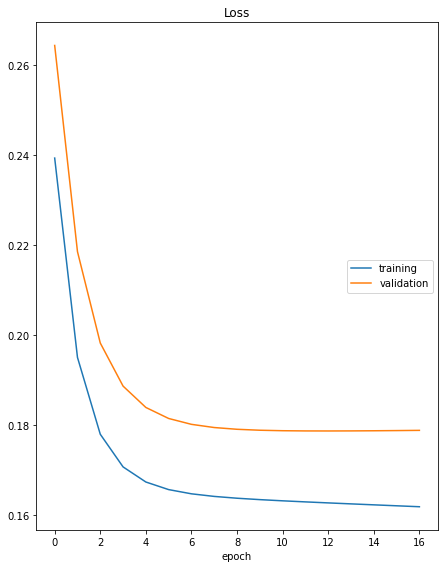

Loss
	training         	 (min:    0.162, max:    0.239, cur:    0.162)
	validation       	 (min:    0.179, max:    0.264, cur:    0.179)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.044128,0.119823,0.162933,0.225051,0.044128,0.087353,0.105369,0.125184


In [25]:
from recommenders.netflix_recommender import NetflixRecommender

netflix_recommender = NetflixRecommender(embedding_dim=8, n_epochs=20, print_type='live')

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, interactions_df, items_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

In [ ]:
tts_results = pd.concat([nn_tts_results, amazon_tts_results, netflix_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

# Summary

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Write a summary of your experiments. What worked well and what did not? What are your thoughts how could you possibly further improve the model?